In [65]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, Activation, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

In [66]:
print(tf.__version__)

2.17.0


In [67]:
#importing csvs into a dataframe and looking at data
df_restock = pd.read_csv("Restock_data.csv")
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04 18:09:57.986537,USD,359.58
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06 15:19:35.630031,USD,344.69
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15 12:10:01.056616,USD,338.48
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24 15:04:48.844780,USD,43.08
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30 14:29:48.834370,USD,177.15


In [68]:
#importing into a dataframe and looking at data
df_inventory = pd.read_csv('Inventory_Turnover.csv')
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed
0,05d98e5c2603bf927952aa3eb74d1fc3,22-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20
1,05d98e5c2603bf927952aa3eb74d1fc3,21-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9
2,05d98e5c2603bf927952aa3eb74d1fc3,20-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15
3,05d98e5c2603bf927952aa3eb74d1fc3,19-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13
4,05d98e5c2603bf927952aa3eb74d1fc3,18-02-2024,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24


In [69]:
#looking at info for data
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38982 entries, 0 to 38981
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sku            38982 non-null  object
 1   dispense_date  38982 non-null  object
 2   device_id      38982 non-null  object
 3   package_qty    38982 non-null  int64 
 4   qty_dispensed  38982 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [70]:
#converting date column to date type
df_inventory['dispense_date'] = df_inventory['dispense_date'].astype('datetime64[s]')
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38982 entries, 0 to 38981
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   sku            38982 non-null  object       
 1   dispense_date  38982 non-null  datetime64[s]
 2   device_id      38982 non-null  object       
 3   package_qty    38982 non-null  int64        
 4   qty_dispensed  38982 non-null  int64        
dtypes: datetime64[s](1), int64(2), object(2)
memory usage: 1.5+ MB


In [71]:
#making a copy for other analysis
df_inventory2 = df_inventory.copy()
df_inventory2.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24


In [72]:
#creating a new month column
df_inventory['month'] = df_inventory['dispense_date'].dt.month_name()
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February


In [73]:
#creating a new day column
df_inventory['day'] = df_inventory['dispense_date'].dt.day_name()
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month,day
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February,Thursday
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February,Wednesday
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February,Tuesday
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February,Monday
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February,Sunday


In [74]:
#creating a new column with the year
df_inventory['year'] = df_inventory['dispense_date'].dt.year
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month,day,year
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February,Thursday,2024
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February,Wednesday,2024
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February,Tuesday,2024
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February,Monday,2024
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February,Sunday,2024


In [75]:
#looking at info for data
df_restock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   device_id        722 non-null    object 
 1   global_order_id  722 non-null    object 
 2   restock_date     722 non-null    object 
 3   currency_code    722 non-null    object 
 4   total            722 non-null    float64
dtypes: float64(1), object(4)
memory usage: 28.3+ KB


In [76]:
#converting date column to date/time and removing the extra decimals
df_restock['restock_date'] = pd.to_datetime(df_restock['restock_date'])
df_restock['restock_date'] = df_restock['restock_date'].dt.date
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04,USD,359.58
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06,USD,344.69
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15,USD,338.48
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24,USD,43.08
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30,USD,177.15


In [77]:
#making sure dtype converted correctly
df_restock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   device_id        722 non-null    object 
 1   global_order_id  722 non-null    object 
 2   restock_date     722 non-null    object 
 3   currency_code    722 non-null    object 
 4   total            722 non-null    float64
dtypes: float64(1), object(4)
memory usage: 28.3+ KB


In [78]:
#creating new column for month
df_restock['month'] = pd.DatetimeIndex(df_restock['restock_date']).month_name()
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04,USD,359.58,December
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06,USD,344.69,November
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15,USD,338.48,May
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24,USD,43.08,January
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30,USD,177.15,June


In [79]:
#creating new column with day
df_restock['day'] = pd.DatetimeIndex(df_restock['restock_date']).day_name()
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month,day
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04,USD,359.58,December,Monday
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06,USD,344.69,November,Monday
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15,USD,338.48,May,Monday
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24,USD,43.08,January,Wednesday
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30,USD,177.15,June,Friday


In [80]:
#creating new column with year
df_restock['year'] = pd.DatetimeIndex(df_restock['restock_date']).year
df_restock.head()

,device_id,global_order_id,restock_date,currency_code,total,month,day,year
0,device_0749c361d8ac7047c2f98fbcb2eadd16,05f46e618fbb92810f9eed53e2f55a73,2023-12-04,USD,359.58,December,Monday,2023
1,device_65ae7ea424c57d46ac409256fe359349,9af13752287b4011aa8c67572db4fe4a,2023-11-06,USD,344.69,November,Monday,2023
2,device_af645ebf4c96eb6e430529a2a9913686,c444a49754db44199ee59310ab427e53,2023-05-15,USD,338.48,May,Monday,2023
3,device_0749c361d8ac7047c2f98fbcb2eadd16,08dd5a4c6a1d406a3d7f5f2c9f63e752,2024-01-24,USD,43.08,January,Wednesday,2024
4,device_0749c361d8ac7047c2f98fbcb2eadd16,9bfc4033193d4556360b4729fe25e75c,2023-06-30,USD,177.15,June,Friday,2023


In [81]:
#looking at percentages for missing data
total = df_inventory.isnull().sum().sort_values(ascending=False)
percent = (df_inventory.isnull().sum()/df_inventory.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

               Total  Percent
sku                0      0.0
dispense_date      0      0.0
device_id          0      0.0
package_qty        0      0.0
qty_dispensed      0      0.0
month              0      0.0
day                0      0.0
year               0      0.0


In [82]:
#looking at percentages for missing data
total = df_restock.isnull().sum().sort_values(ascending=False)
percent = (df_restock.isnull().sum()/df_restock.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

                 Total  Percent
device_id            0      0.0
global_order_id      0      0.0
restock_date         0      0.0
currency_code        0      0.0
total                0      0.0
month                0      0.0
day                  0      0.0
year                 0      0.0


In [83]:
#looking for duplicates
df_restock.duplicated().value_counts()


False    722
Name: count, dtype: int64

In [84]:
#looking for duplicates
df_inventory.duplicated().value_counts()

False    38982
Name: count, dtype: int64

In [85]:
#looking at data distribution
df_inventory.describe()

,dispense_date,package_qty,qty_dispensed,year
count,38982,38982.000000,38982.000000,38982.000000
mean,2023-02-11 16:00:06,1.000487,8.145503,2022.614771
min,2022-01-03 00:00:00,1.000000,1.000000,2022.000000
25%,2022-08-03 00:00:00,1.000000,2.000000,2022.000000
50%,2023-02-04 00:00:00,1.000000,5.000000,2023.000000
75%,2023-08-16 00:00:00,1.000000,12.000000,2023.000000
max,2024-12-02 00:00:00,2.000000,162.000000,2024.000000
std,NaN,0.022072,9.055199,0.610529


In [86]:
#looking at data distribution
df_restock.describe()

,total,year
count,722.000000,722.000000
mean,272.511260,2023.252078
std,101.077273,0.434507
min,5.090000,2023.000000
25%,207.997500,2023.000000
50%,271.385000,2023.000000
75%,338.707500,2024.000000
max,612.210000,2024.000000


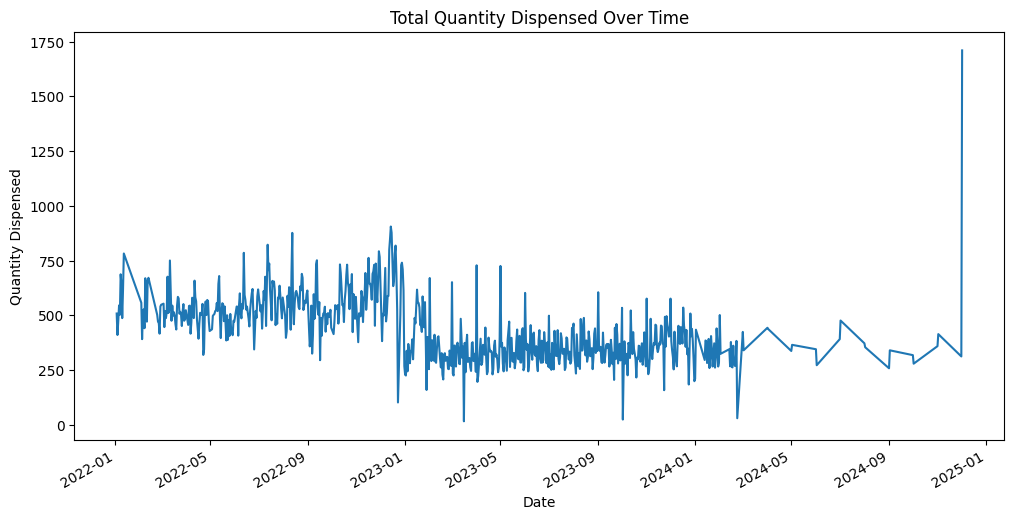

In [33]:
plt.figure(figsize=(12, 6))
df_inventory.groupby('dispense_date')['qty_dispensed'].sum().plot()
plt.title('Total Quantity Dispensed Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Dispensed')
plt.show()

In [23]:
#grouping data
df_inventory2.set_index('dispense_date', inplace=True)
grouped_data = df_inventory2['qty_dispensed'].resample('ME').sum()
grouped_data = grouped_data.asfreq('ME')

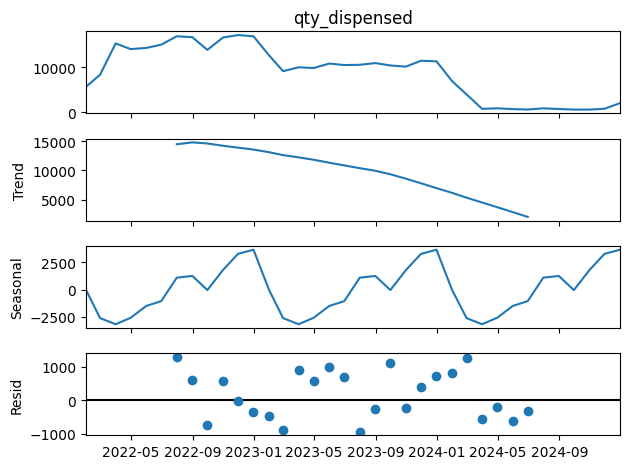

In [35]:
#checking seasonality trends
decomposition = seasonal_decompose(grouped_data, model='additive')
decomposition.plot()
plt.show()

df_inventory['dispense_date'] = pd.to_datetime(df_inventory['dispense_date'])

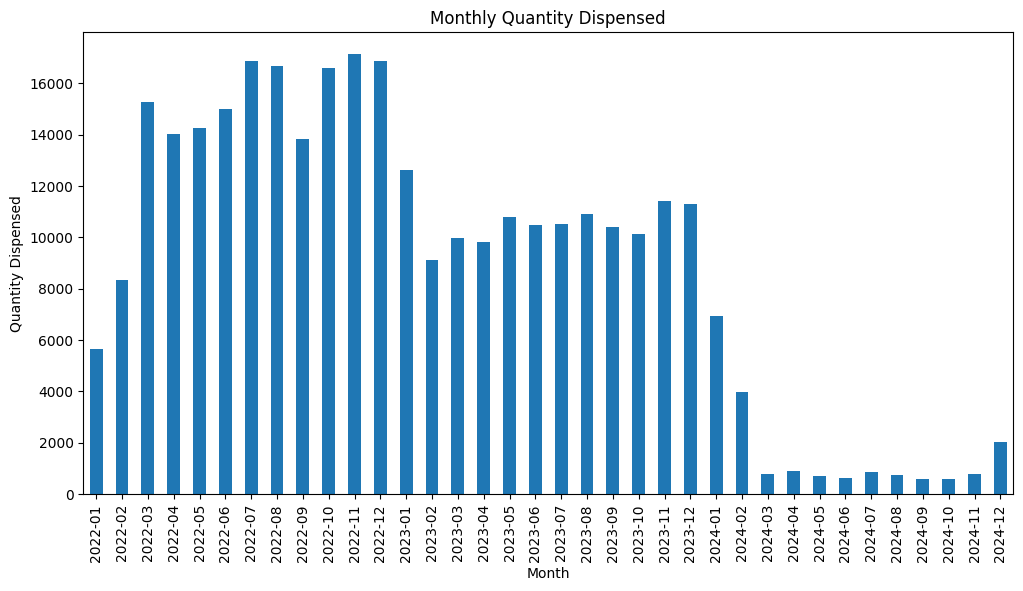

In [36]:
#Seasonal patterns
monthly_trend = df_inventory.groupby(df_inventory['dispense_date'].dt.to_period('M'))['qty_dispensed'].sum()
monthly_trend.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Quantity Dispensed')
plt.xlabel('Month')
plt.ylabel('Quantity Dispensed')
plt.show()

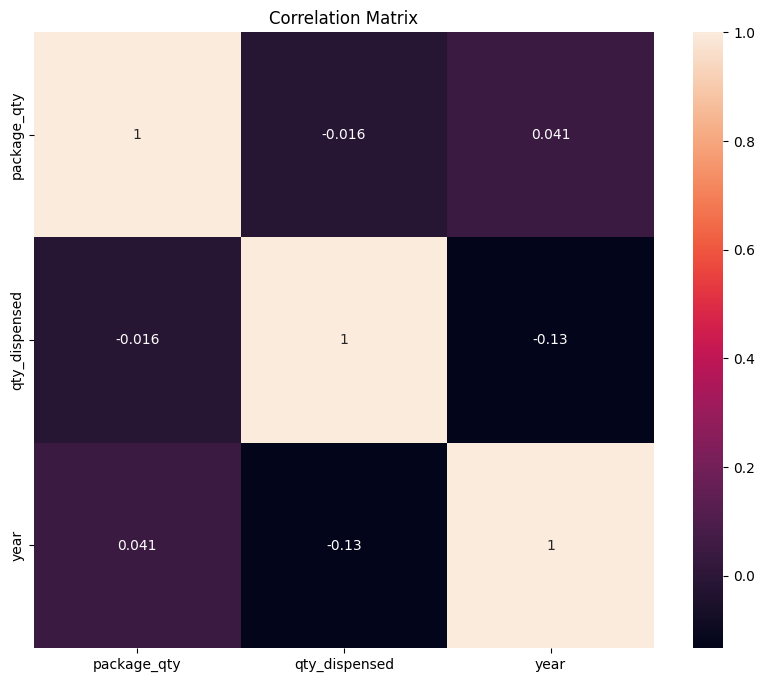

In [37]:
numeric_df = df_inventory.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

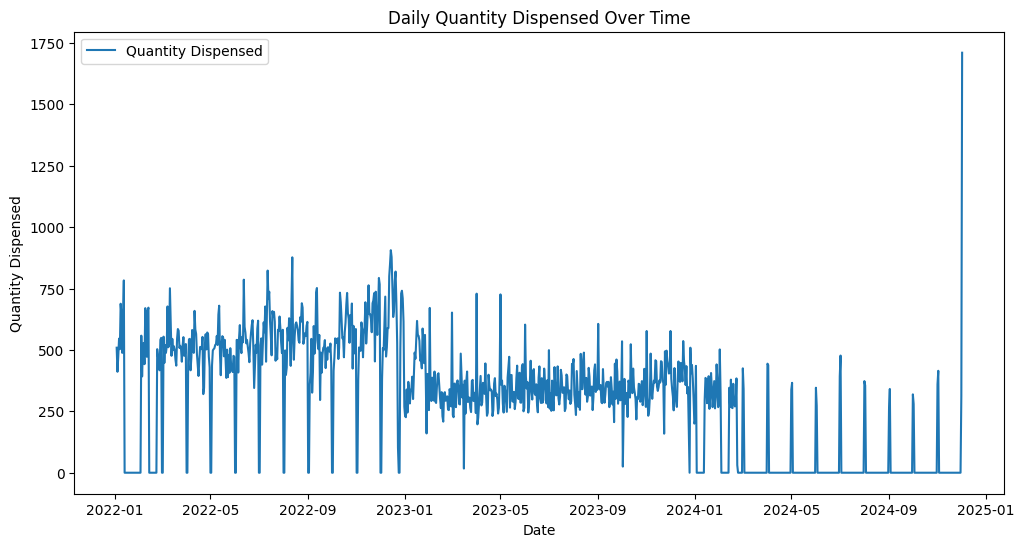

In [89]:
plt.figure(figsize=(12, 6))
daily_demand = df_inventory.resample('D').sum()
plt.plot(daily_demand.index, daily_demand['qty_dispensed'], label='Quantity Dispensed')
plt.title('Daily Quantity Dispensed Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Dispensed')
plt.legend()
plt.show()

<Axes: xlabel='day', ylabel='qty_dispensed'>

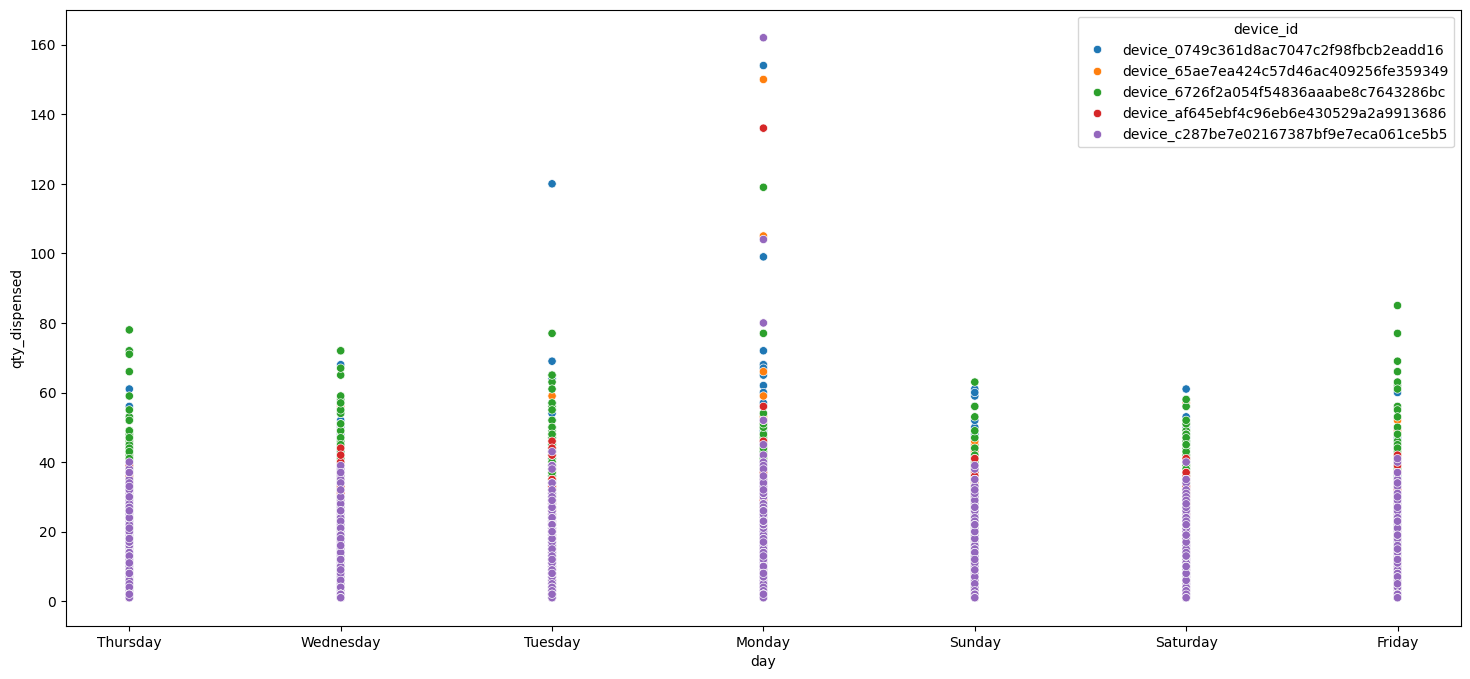

In [38]:
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_inventory, x="day", y="qty_dispensed", hue="device_id")

<Axes: xlabel='day', ylabel='sku'>

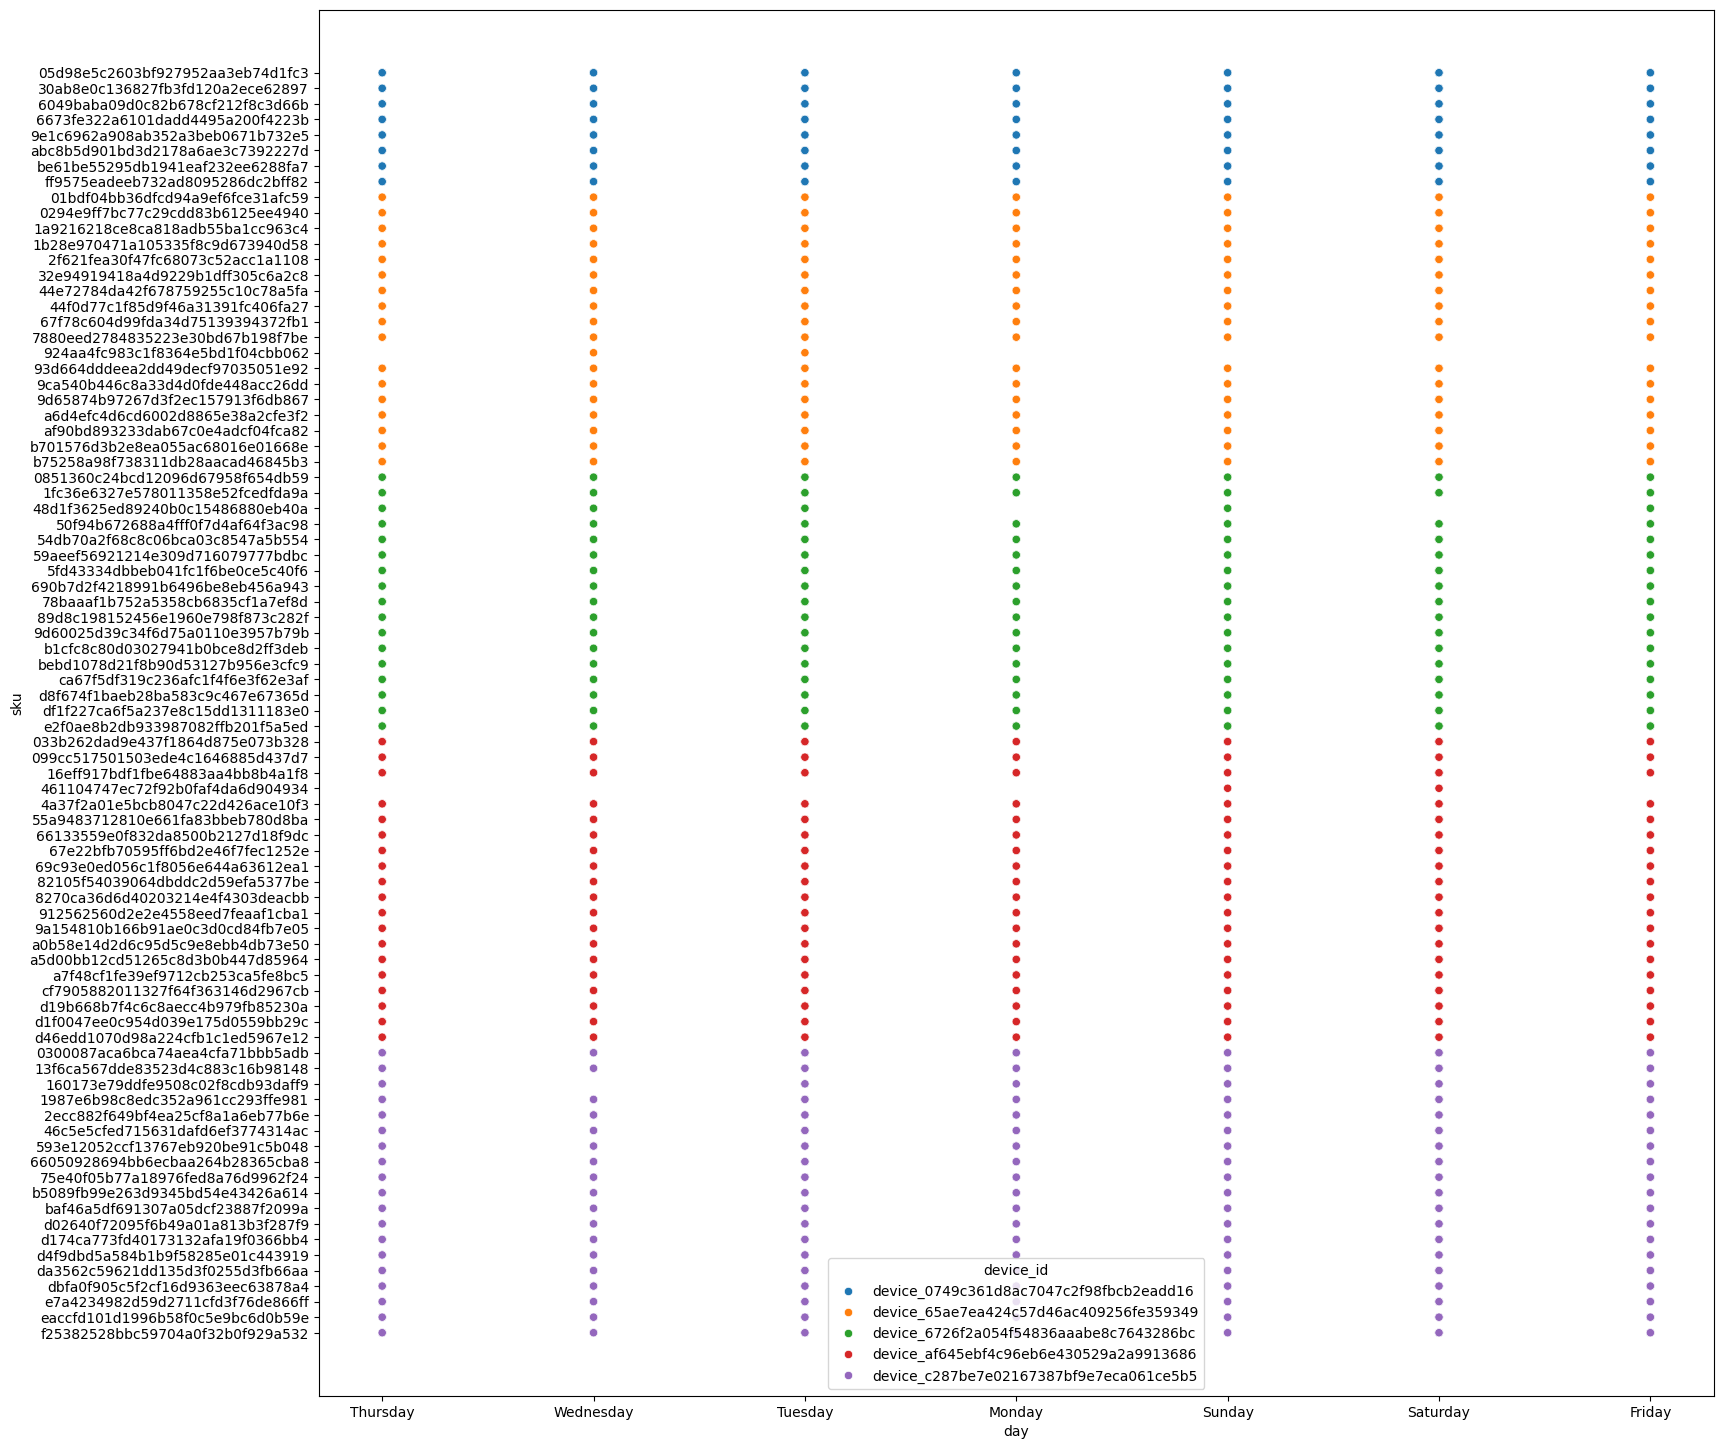

In [91]:
plt.figure(figsize=(18,18))
sns.scatterplot(data=df_inventory, x="day", y="sku", hue="device_id")

<Axes: xlabel='year'>

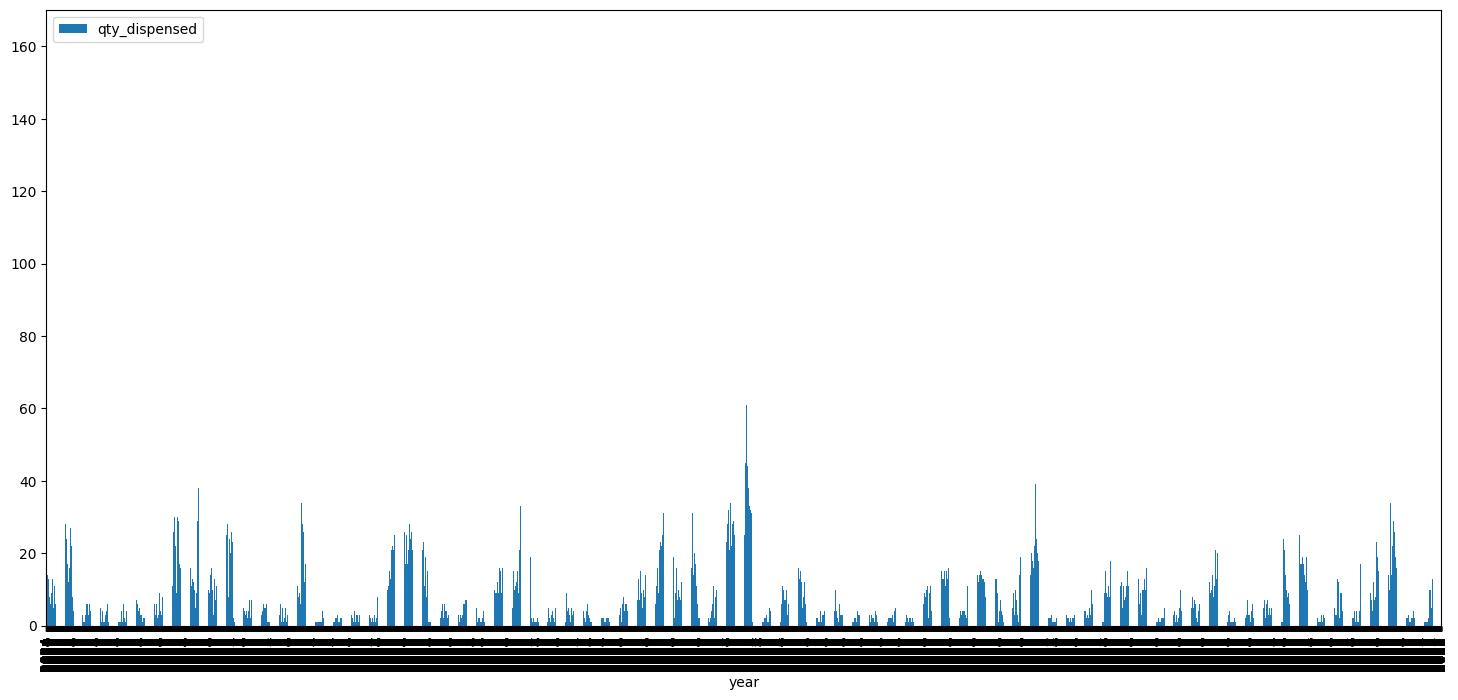

In [39]:

df_inventory.plot.bar(x="year", y="qty_dispensed", figsize=(18,8))

<Axes: xlabel='qty_dispensed', ylabel='year'>

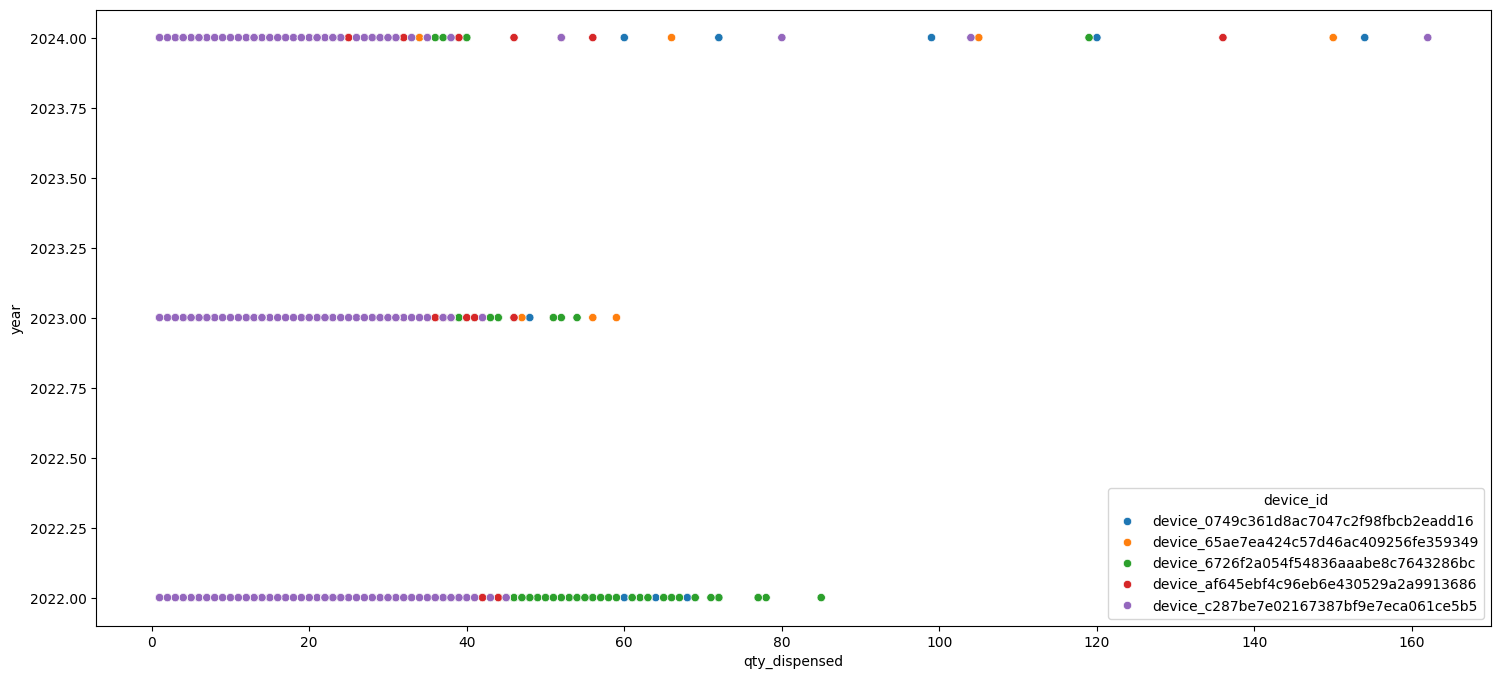

In [41]:
#looking to see if there's any correlation between the dates, device, and total amount
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_inventory, x="qty_dispensed", y="year", hue="device_id")

<Axes: xlabel='restock_date', ylabel='total'>

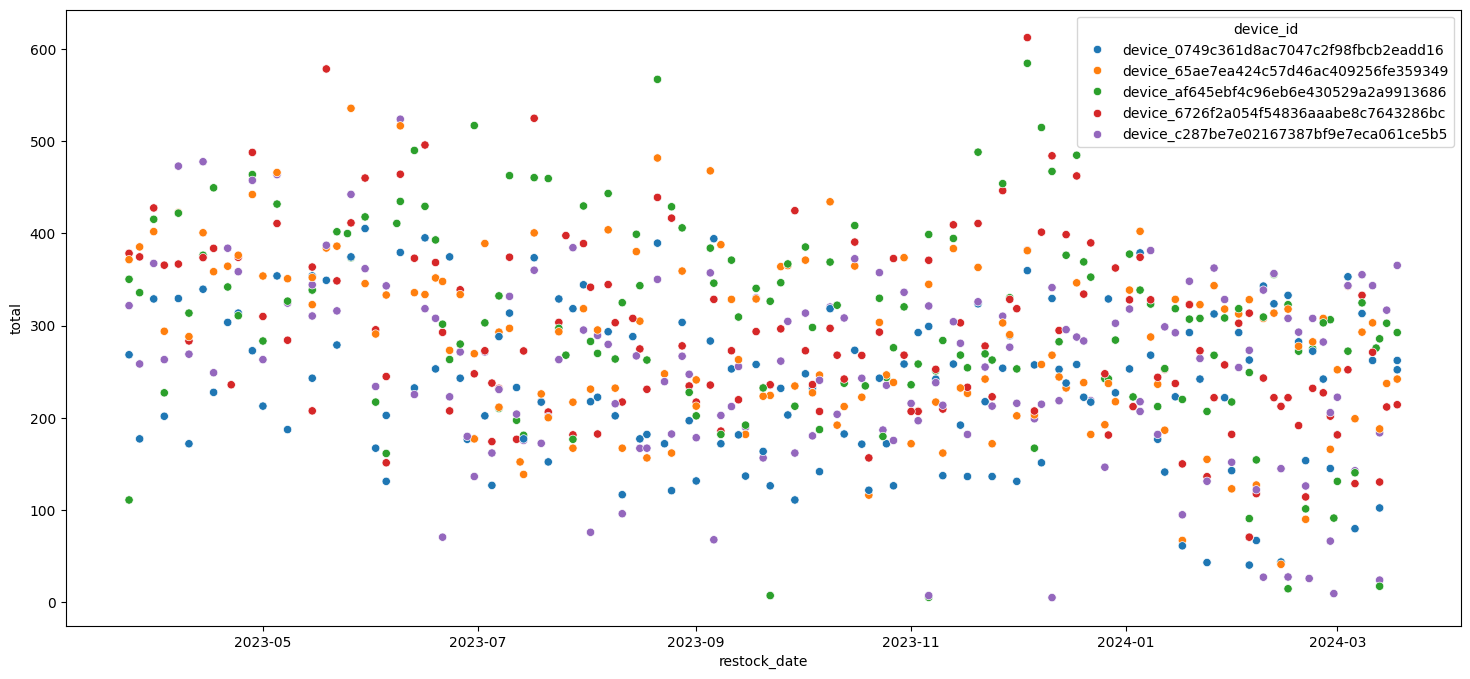

In [42]:
#looking to see if there's any correlation between the dates, device, and total amount
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_restock, x="restock_date", y="total", hue="device_id")

<Axes: xlabel='month', ylabel='total'>

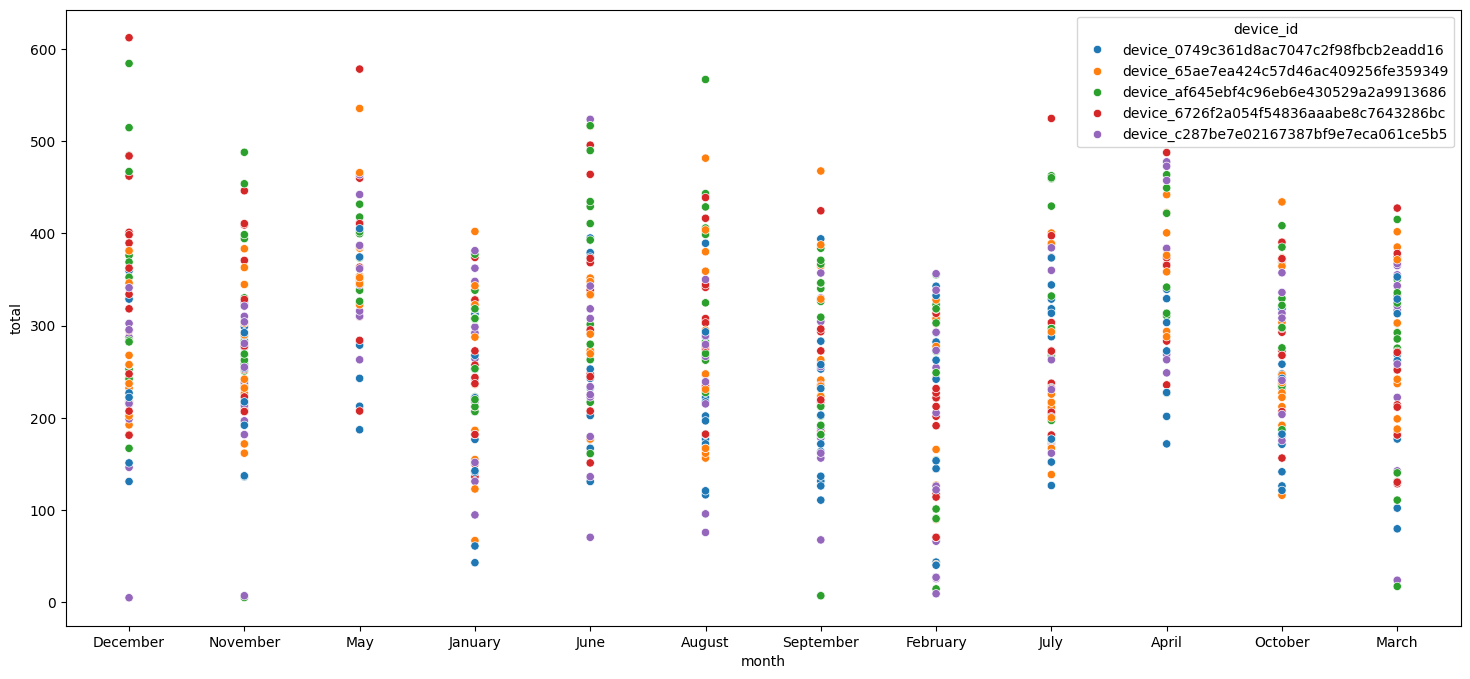

In [43]:
#looking to see if there's any correlation between the dates, device, and total amount
plt.figure(figsize=(18,8))
sns.scatterplot(data=df_restock, x="month", y="total", hue="device_id")

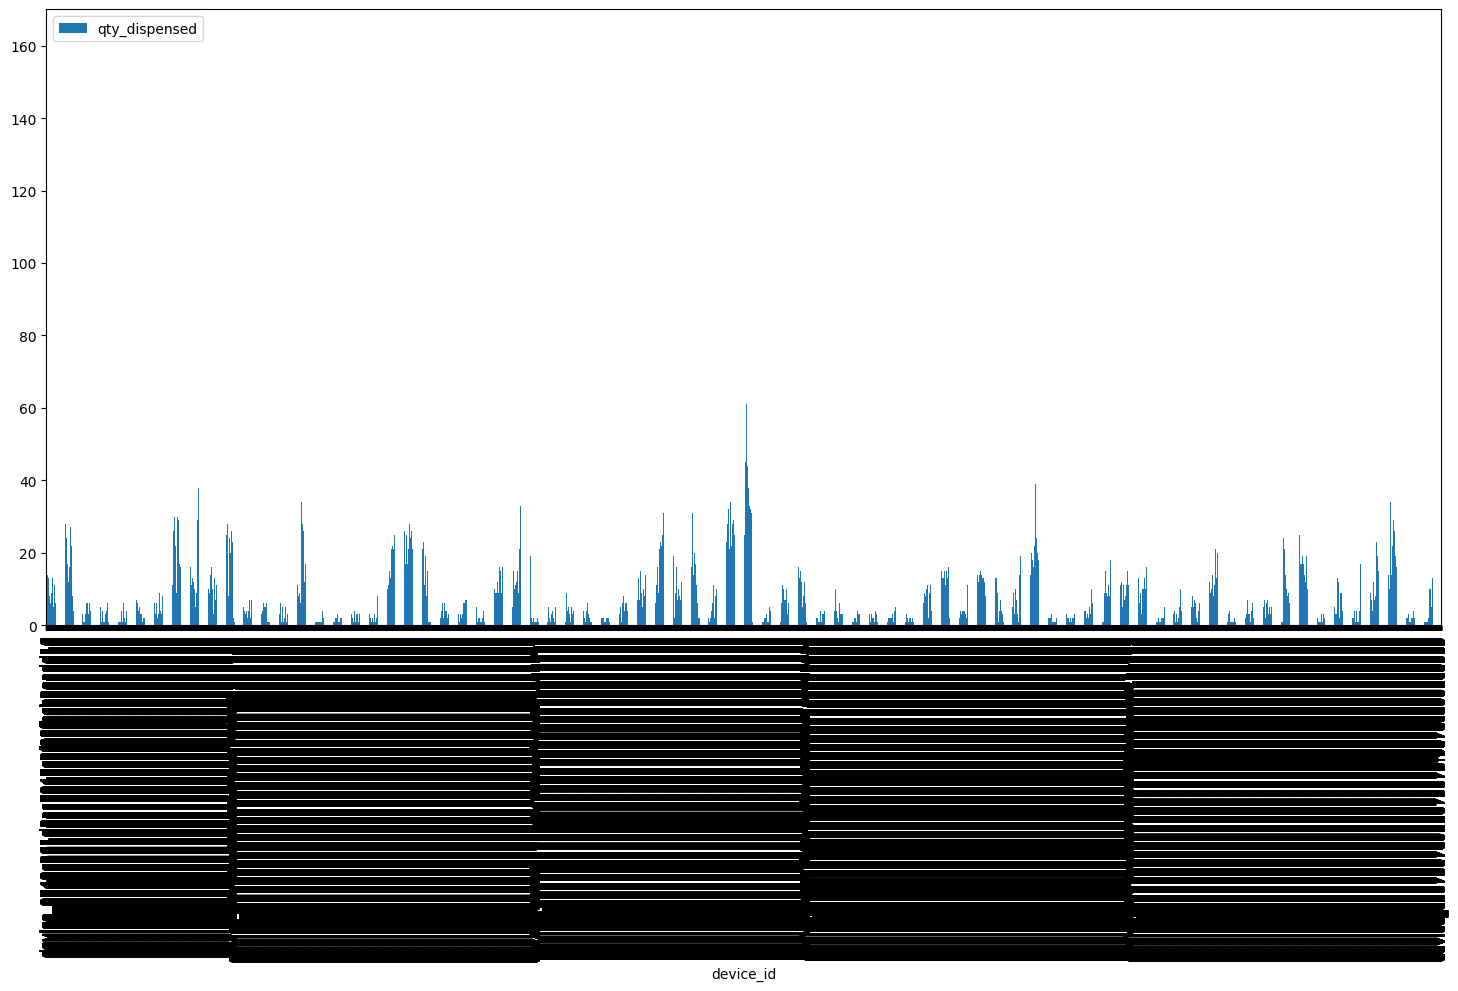

In [44]:
ax = df_inventory.plot.bar(x='device_id', y='qty_dispensed', figsize=(18,8))

<Axes: xlabel='restock_date'>

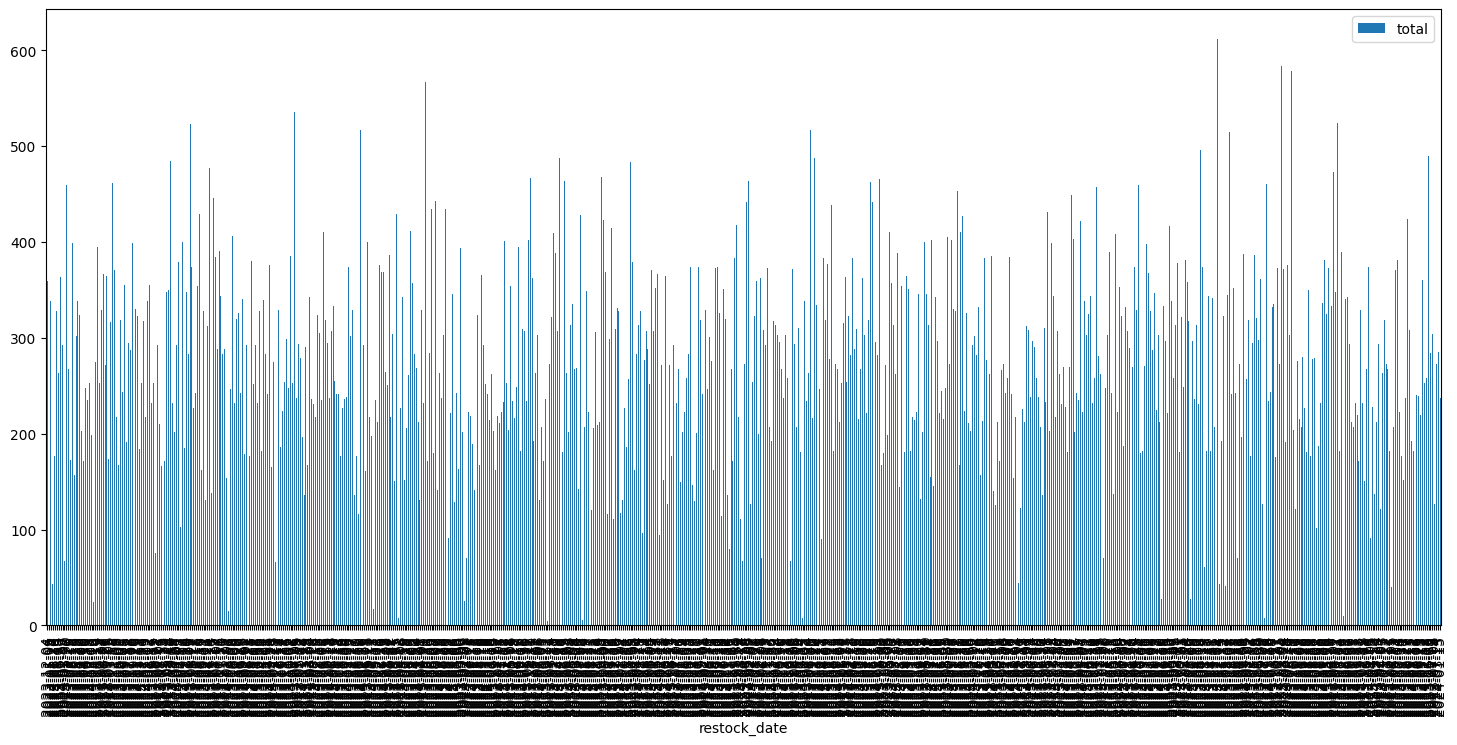

In [45]:

df_restock.plot.bar(x = 'restock_date', y = 'total', figsize=(18,8))


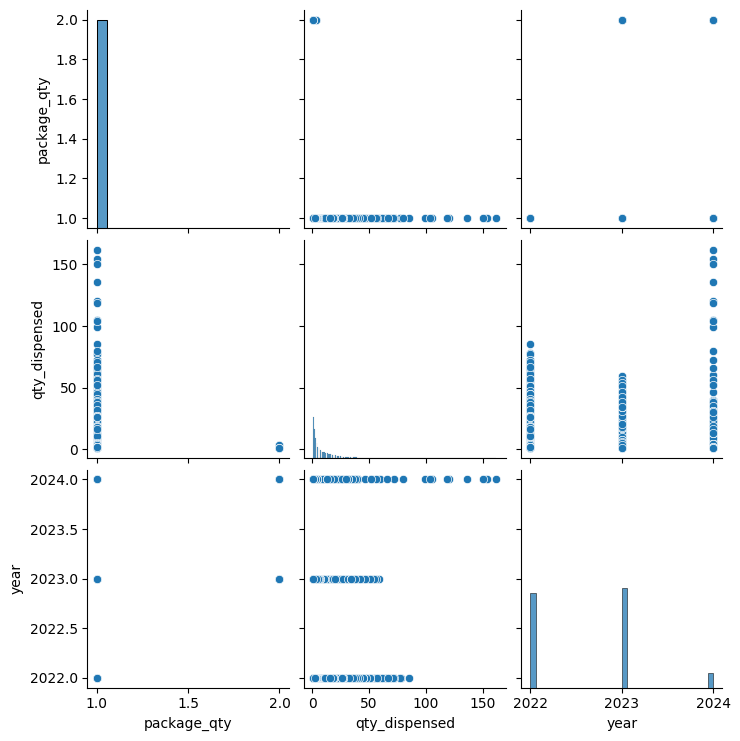

In [46]:
#pairplot of all numeric variables
sns.pairplot(df_inventory)
plt.show()

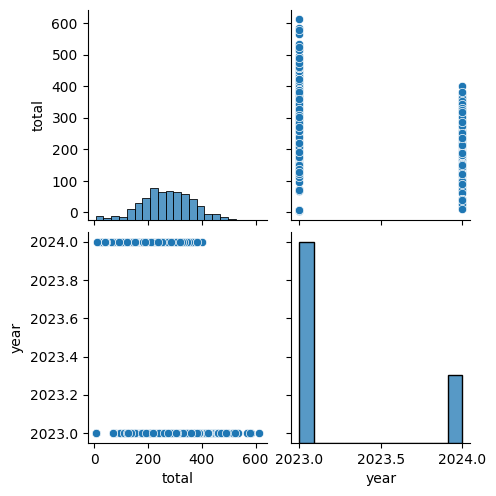

In [47]:
#pairplot of all numeric variables
sns.pairplot(df_restock)
plt.show()

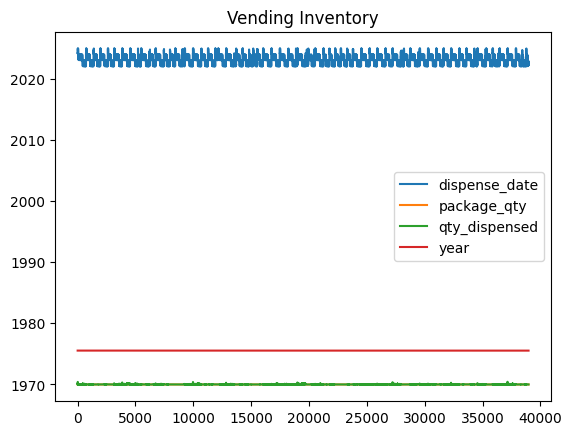

In [48]:
df_inventory.plot()
plt.title("Vending Inventory")
plt.show()

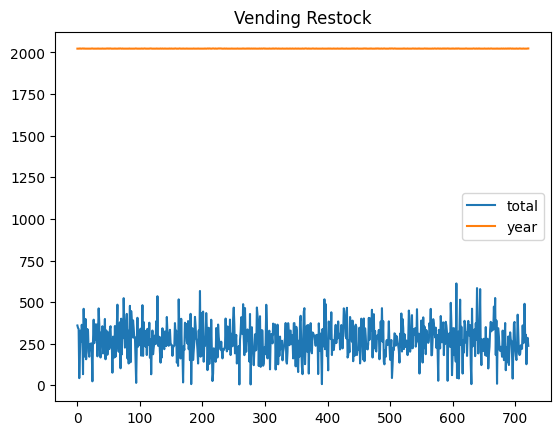

In [49]:
df_restock.plot()
plt.title("Vending Restock")
plt.show()

<Axes: >

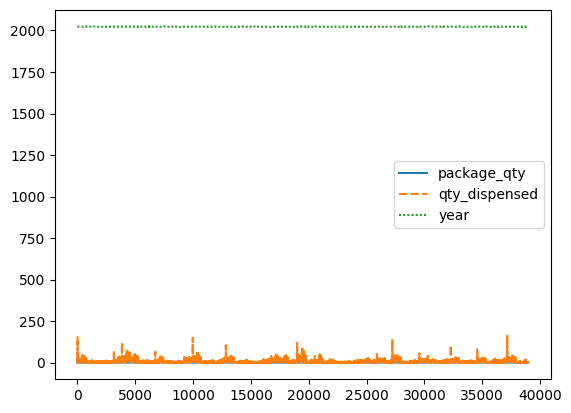

In [34]:
sns.lineplot(df_inventory)

<Axes: >

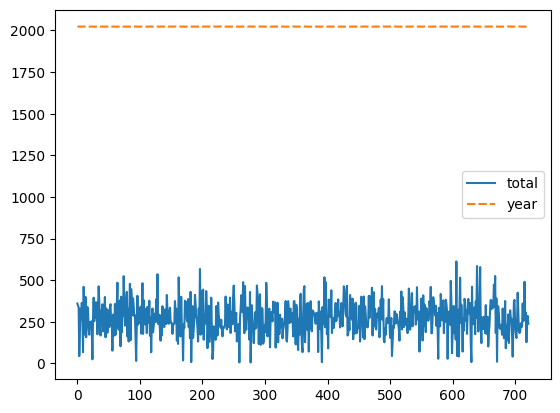

In [35]:
sns.lineplot(df_restock)

In [87]:
df_inventory.dtypes

sku                     object
dispense_date    datetime64[s]
device_id               object
package_qty              int64
qty_dispensed            int64
month                   object
day                     object
year                     int32
dtype: object

In [88]:
df_i_num = df_inventory.select_dtypes(include=['number'])

In [89]:
df_i_num.dtypes

package_qty      int64
qty_dispensed    int64
year             int32
dtype: object

In [90]:
df_restock.dtypes

device_id           object
global_order_id     object
restock_date        object
currency_code       object
total              float64
month               object
day                 object
year                 int32
dtype: object

In [91]:
df_r_num = df_restock.select_dtypes(include=['number'])

In [92]:
df_r_num.dtypes

total    float64
year       int32
dtype: object

In [93]:
rolling_mean = df_i_num.rolling(7).mean()
rolling_std = df_i_num.rolling(7).std()

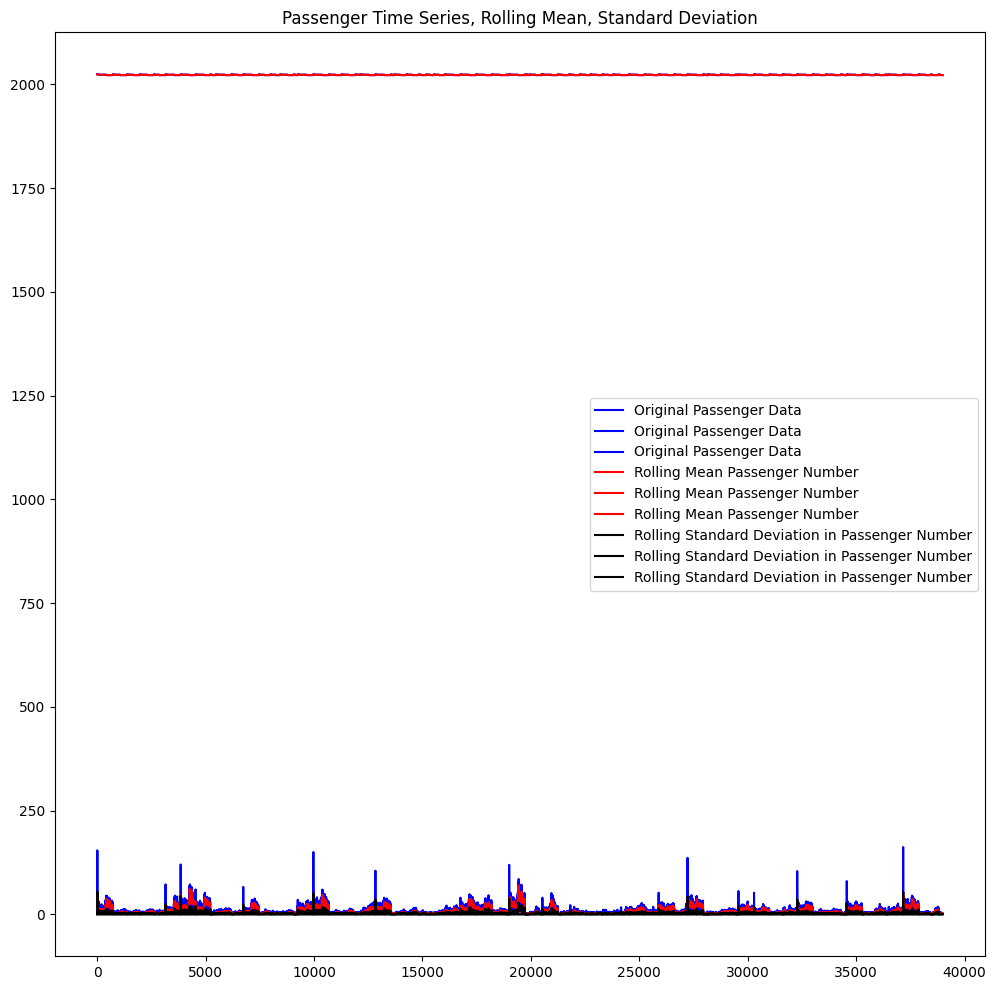

In [94]:
plt.figure(figsize=(12, 12))
plt.plot(df_i_num, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [119]:
for column in df_i_num.columns:
    result = adfuller(df_i_num[column], autolag="AIC")
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value for {column}: {result[1]}")

ADF Statistic for package_qty: -24.71689797865449
p-value for package_qty: 0.0
ADF Statistic for qty_dispensed: -7.833174750394803
p-value for qty_dispensed: 6.214371242230743e-12
ADF Statistic for year: -14.072233755378628
p-value for year: 2.926473726668958e-26


In [120]:
df_i_num.head()

,package_qty,qty_dispensed,year
0,1,20,2024
1,1,9,2024
2,1,15,2024
3,1,13,2024
4,1,24,2024


In [122]:
adft = adfuller(df_i_num['qty_dispensed'],autolag="AIC")

In [123]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -7.833175e+00              Test Statistics
1  6.214371e-12                      p-value
2  4.700000e+01             No. of lags used
3  3.893400e+04  Number of observations used
4 -3.430518e+00          critical value (1%)
5 -2.861614e+00          critical value (5%)
6 -2.566810e+00         critical value (10%)


In [125]:
autocorrelation_lag1 = df_i_num['qty_dispensed'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df_i_num['qty_dispensed'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df_i_num['qty_dispensed'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df_i_num['qty_dispensed'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.8136142989386776
Three Month Lag:  0.7748351180148517
Six Month Lag:  0.8009673528560491
Nine Month Lag:  0.7570659515415487


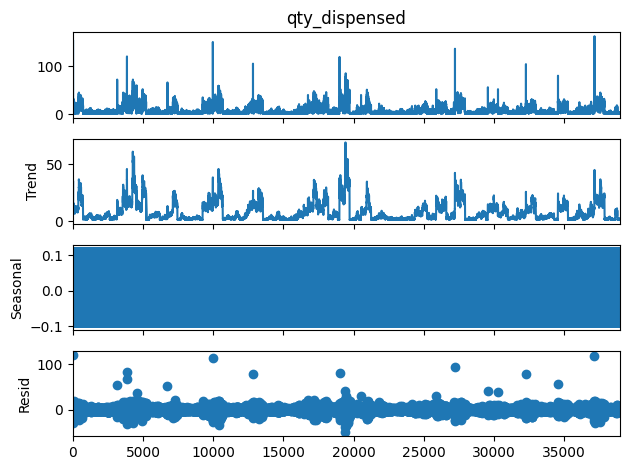

In [126]:
decompose = seasonal_decompose(df_i_num['qty_dispensed'],model='additive', period=7)
decompose.plot()
plt.show()

In [137]:
df_i_num['year'] = pd.to_datetime(df_i_num['year'], errors='coerce')
print(df_i_num['year'].isna().sum())

0


In [139]:
train = df_i_num[df_i_num['year'] < pd.to_datetime("2025-01-01")]
train['train'] = train['qty_dispensed']
del train['year']
del train['qty_dispensed']
test = df_i_num[df_i_num['year'] >= pd.to_datetime("2025", format='%Y')]
del test['year']
test['test'] = test['qty_dispensed']
del test['qty_dispensed']

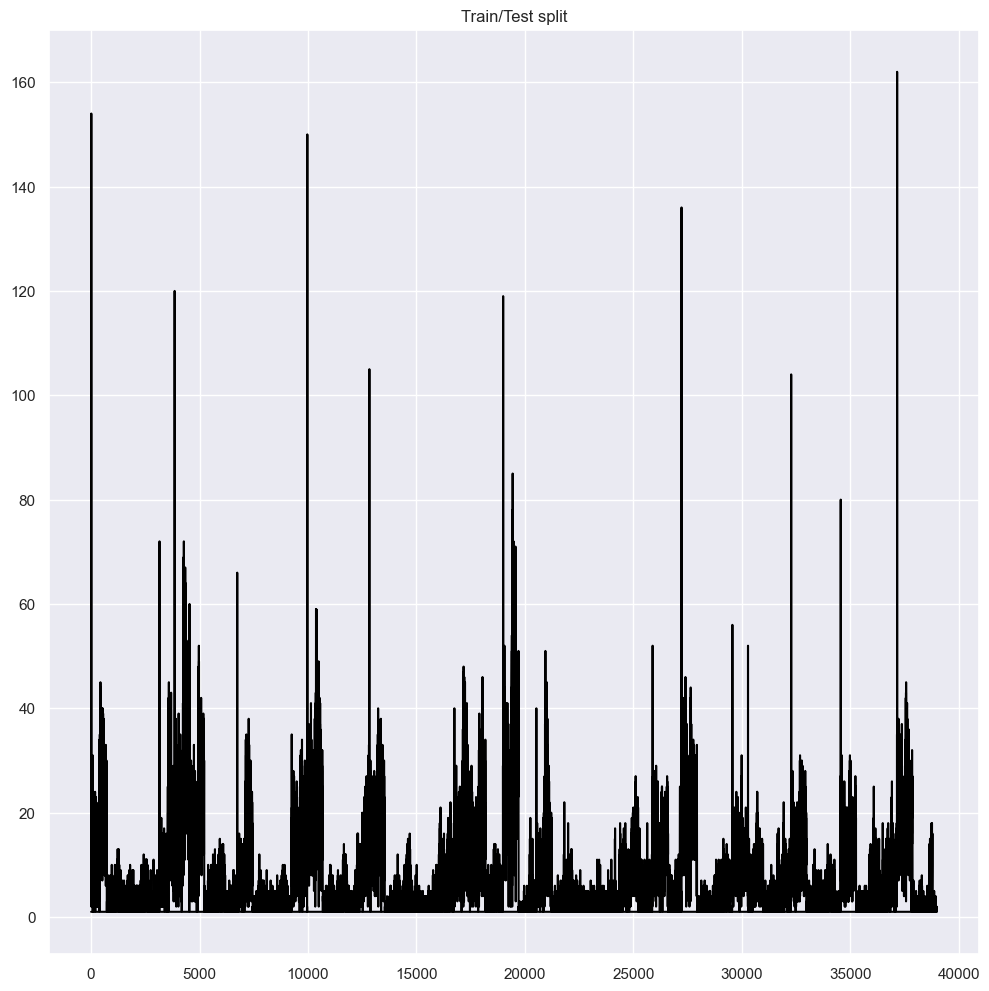

In [141]:
plt.figure(figsize=(12, 12))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split")
sns.set()
plt.show()

In [143]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

ValueError: y should be a 1d array, got an array of shape (38982, 2) instead.

In [96]:
# Group by SKU and date for aggregated features
sku_demand = df_inventory.groupby(['sku', 'dispense_date']).agg({'qty_dispensed': 'sum'}).reset_index()

# Pivot the data to create a time series for each SKU
sku_pivot = sku_demand.pivot(index='dispense_date', columns='sku', values='qty_dispensed').fillna(0)

In [97]:
#normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sku_pivot)

In [98]:
#create sequences
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

In [99]:
# Define time step and split data
time_step = 30
X, y = create_sequences(scaled_data, time_step)

In [100]:
# Reshape for LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))  # Output layer for multiple SKUs
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

C:\Users\brean\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0513
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0216
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0187
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183
E

In [103]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform to get original values
predictions_inverse = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


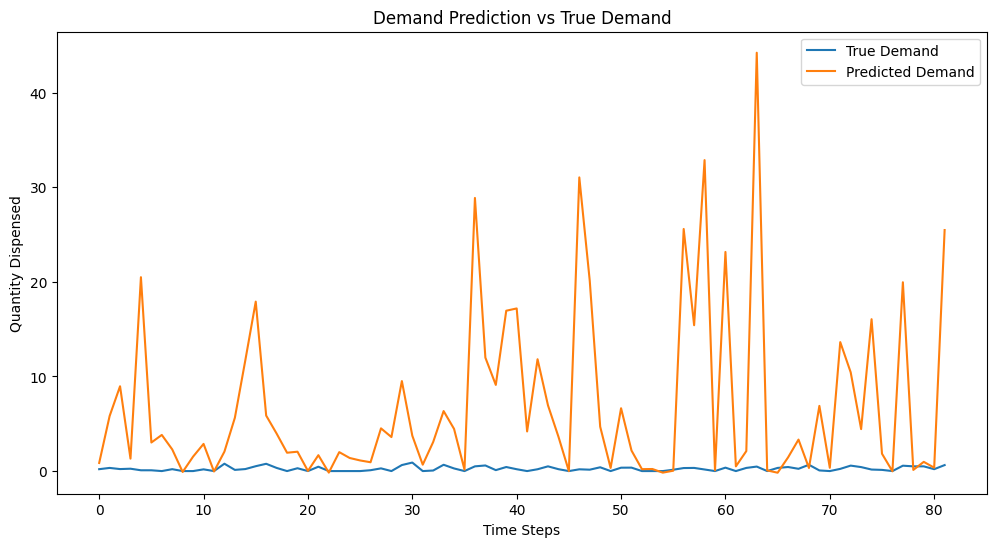

In [104]:
# Evaluate predictions (Example: plotting)
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label='True Demand')
plt.plot(predictions_inverse[0], label='Predicted Demand')
plt.title('Demand Prediction vs True Demand')
plt.xlabel('Time Steps')
plt.ylabel('Quantity Dispensed')
plt.legend()
plt.show()

In [110]:
predictions = (predictions > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

In [111]:
print(f'y_test shape: {y_test.shape}, dtype: {y_test.dtype}')
print(f'predictions shape: {predictions.shape}, dtype: {predictions.dtype}')

y_test shape: (140, 82), dtype: float64
predictions shape: (140, 82), dtype: int32


In [113]:
print('Accuracy Score : ' + str(accuracy_score(y_test_binary,predictions)))
print('Precision Score : ' + str(precision_score(y_test_binary,predictions, average='micro')))
print('Recall Score : ' + str(recall_score(y_test_binary,predictions, average='micro')))
print('F1 Score : ' + str(f1_score(y_test_binary,predictions, average='micro')))

Accuracy Score : 0.2
Precision Score : 0.4602272727272727
Recall Score : 0.1480804387568556
F1 Score : 0.22406639004149378


In [50]:
df_inventory['lag_1'] = df_inventory['qty_dispensed'].shift(1)
df_inventory['lag_2'] = df_inventory['qty_dispensed'].shift(2)
df_inventory.head()

,sku,dispense_date,device_id,package_qty,qty_dispensed,month,day,year,lag_1,lag_2
0,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-22,device_0749c361d8ac7047c2f98fbcb2eadd16,1,20,February,Thursday,2024,NaN,NaN
1,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-21,device_0749c361d8ac7047c2f98fbcb2eadd16,1,9,February,Wednesday,2024,20.0,NaN
2,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-20,device_0749c361d8ac7047c2f98fbcb2eadd16,1,15,February,Tuesday,2024,9.0,20.0
3,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-19,device_0749c361d8ac7047c2f98fbcb2eadd16,1,13,February,Monday,2024,15.0,9.0
4,05d98e5c2603bf927952aa3eb74d1fc3,2024-02-18,device_0749c361d8ac7047c2f98fbcb2eadd16,1,24,February,Sunday,2024,13.0,15.0


In [51]:
#seperating target and feature data
x = df_inventory[['day', 'month', 'year', 'lag_1', 'lag_2']]

#x = df_inventory.loc[:, df_inventory.columns != 'qty_dispensed']
y = df_inventory['qty_dispensed']


In [52]:
#encoded string data and set up train/test split
x_encoded = pd.get_dummies(x, columns=['day'], drop_first=True)
x_encoded = pd.get_dummies(x_encoded, columns=['month'], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, shuffle=False)

In [53]:
# Random Forest Model
random = RandomForestRegressor(n_estimators=100, random_state=42)
random.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [60]:
predictions2 = random.predict(x_test)
pred = np.round(predictions2).astype(int)
pred = np.clip(pred, 1, 162) 
print('Unique values in predictions after conversion:', np.unique(pred))

Unique values in predictions after conversion: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 43 47 79]


In [55]:
mse = mean_squared_error(y_test, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 21.49748311926238


In [58]:
print('Unique values in y_test:', np.unique(y_test))
print('Unique values in predictions:', np.unique(predictions2))

Unique values in y_test: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  45  80 104 162]
Unique values in predictions: [ 1.      1.004   1.0075 ... 42.9655 47.12   79.19  ]


In [62]:
print('Accuracy Score : ' + str(accuracy_score(y_test,pred)))
print('Precision Score : ' + str(precision_score(y_test,pred, average='weighted')))
print('Recall Score : ' + str(recall_score(y_test,pred, average='weighted')))
print('F1 Score : ' + str(f1_score(y_test,pred, average='weighted')))

Accuracy Score : 0.16057457996665384
Precision Score : 0.20404542350517715
Recall Score : 0.16057457996665384
F1 Score : 0.15845045680496156


C:\Users\brean\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\brean\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,pred)))  

Confusion Matrix : 
[[251 821 235 ...   0   0   0]
 [103 485 218 ...   0   0   0]
 [ 67 274 168 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


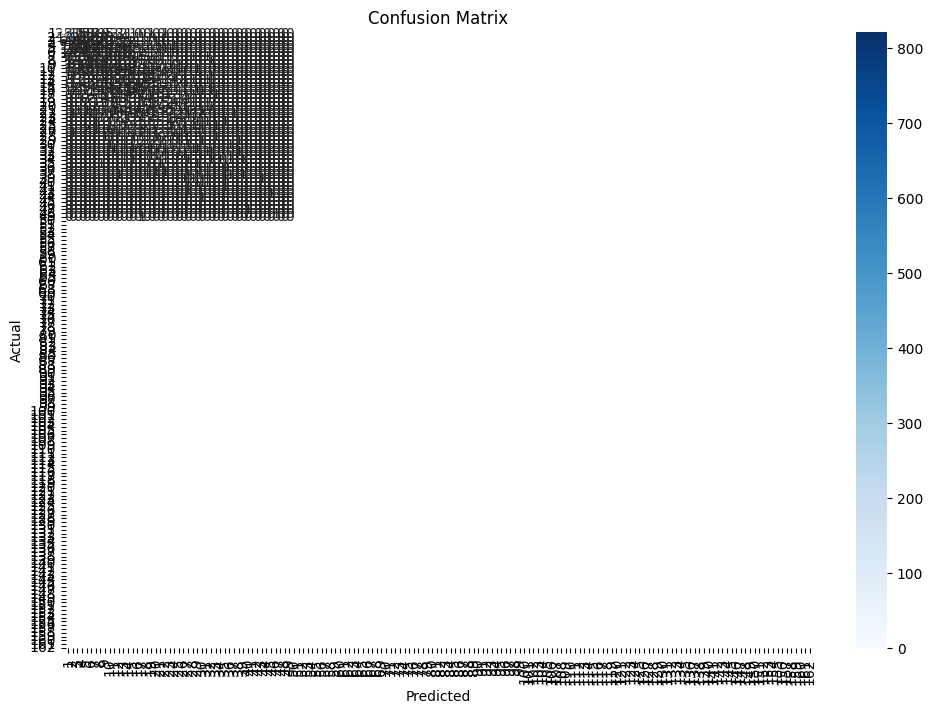

In [66]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 163), yticklabels=range(1, 163))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [86]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_inventory.values.reshape(-1, 1))

ValueError: could not convert string to float: '05d98e5c2603bf927952aa3eb74d1fc3'